## Machine Learning: bikeshare data for Capstone 1

Let's start by adding the rest of 2016 data.

As a reminder, the data can be found here, https://s3.amazonaws.com/capitalbikeshare-data/index.html.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

Q1 = pd.read_csv('../CapstoneDrafts/data/2016Q1-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q2 = pd.read_csv('../CapstoneDrafts/data/2016Q2-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q3 = pd.read_csv('../CapstoneDrafts/data/2016Q3-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q4 = pd.read_csv('../CapstoneDrafts/data/2016Q4-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])

In [2]:
bike2016 = Q1.append([Q2,Q3,Q4])
bike2016.duration = bike2016.duration % 60
print('Number of rows in the dataset for 2016:',len(bike2016))
bike2016.head()

Number of rows in the dataset for 2016: 3333994


,duration,enddate,startlocID,startloc,endlocID,endloc,bikeID,memtype
2016-01-01 00:06:58,46,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
2016-01-01 00:10:20,28,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2016-01-01 00:13:52,55,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
2016-01-01 00:15:29,33,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
2016-01-01 00:16:16,32,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


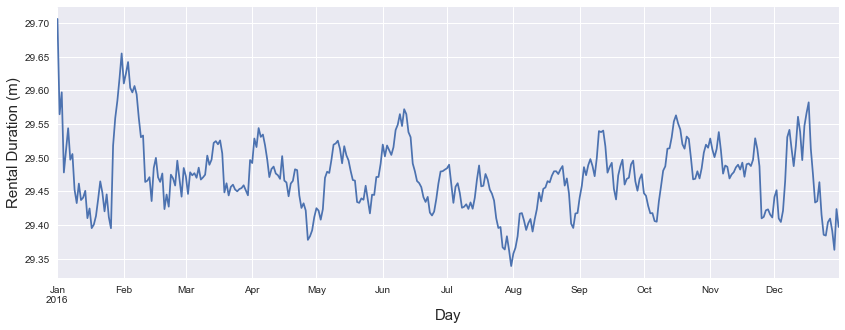

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14,5)
duration = bike2016['duration']
smoothed = duration.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothed.plot(ax=ax)
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Rental Duration (m)',fontsize=15)

Are there different durations for registered versus casual members?

In [4]:
durationReg = bike2016['duration'][bike2016['memtype']=='Member']
durationCas = bike2016['duration'][bike2016['memtype']=='Casual']

smoothedReg = durationReg.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothedCas = durationCas.resample('D').mean().rolling(window=12, min_periods=1).mean()

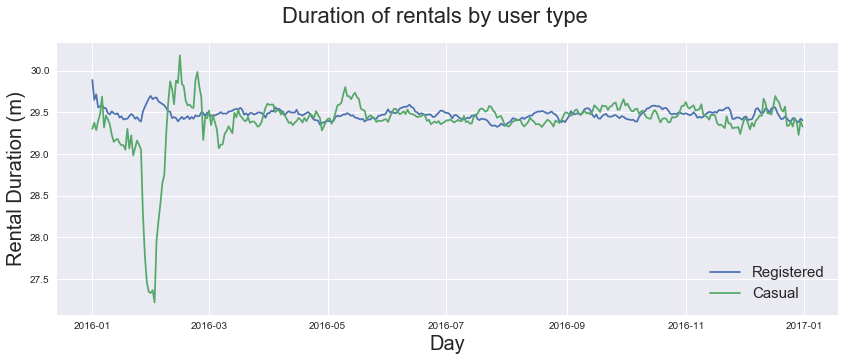

In [5]:
fig, ax = plt.subplots(1)
fig.set_size_inches(14,5)
ax.plot(smoothedReg, label='Registered')
ax.plot(smoothedCas, label='Casual')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Rental Duration (m)',fontsize=20)
fig.suptitle('Duration of rentals by user type', fontsize=22)
ax.legend(fontsize=15)
#plt.savefig('bike_rolling_type',bbox_inches='tight',dpi=300)

In [6]:
bike2016['startdate'] = bike2016.index
bike2016['startweekday'] = bike2016['startdate'].apply(lambda d: d.weekday())

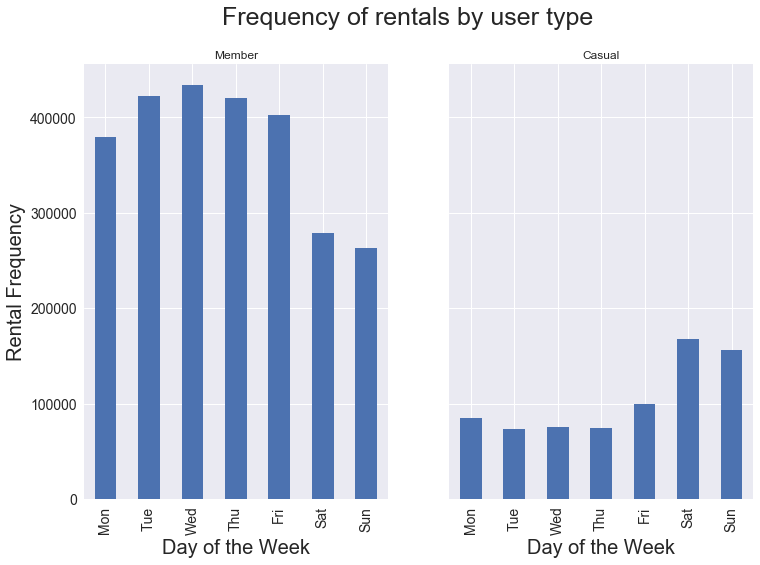

In [7]:
FreqReg=bike2016['startweekday'][bike2016['memtype']=='Member'].value_counts().sort_index()
FreqCas=bike2016['startweekday'][bike2016['memtype']=='Casual'].value_counts().sort_index()
ticks=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] 
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12,8)
FreqReg.plot(kind='bar', ax=axes[0],title='Member',fontsize=14)
FreqCas.plot(kind='bar', ax=axes[1],title='Casual',fontsize=14)
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
fig.suptitle('Frequency of rentals by user type', fontsize=25)
axes[0].set_xlabel('Day of the Week',fontsize=20)
axes[0].set_ylabel('Rental Frequency',fontsize=20)
axes[1].set_xlabel('Day of the Week',fontsize=20)
#plt.savefig('bike_histo_type',bbox='tight',dpi=300)

## Analysis Steps

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: daily max temp, daily min temp, proximity to metro station
- Predict demand on a given day by station ID
    - linear regression/SVM
    - X: julian day, staion ID; y: count/day/station
    - coul add X: daily max temp, daily min temp, proximity to metro station


In [8]:
#find metro station info (euclidian distance... find lat/long of metro stations)
import json
from pandas.io.json import json_normalize

json_data=open('../CapstoneDrafts/data/stations2.json').read()
metro=pd.read_json(json_data, orient='records')
MetroDF = json_normalize(data=metro['Stations'])

print('Number of stations:',len(MetroDF))
MetroDF.head()

Number of stations: 95


,Address.City,Address.State,Address.Street,Address.Zip,Code,Lat,LineCode1,LineCode2,LineCode3,LineCode4,Lon,Name,StationTogether1,StationTogether2
0,Washington,DC,607 13th St. NW,20005,A01,38.898303,RD,None,None,None,-77.028099,Metro Center,C01,
1,Washington,DC,1001 Connecticut Avenue NW,20036,A02,38.903192,RD,None,None,None,-77.039766,Farragut North,,
2,Washington,DC,1525 20th St. NW,20036,A03,38.909499,RD,None,None,None,-77.043620,Dupont Circle,,
3,Washington,DC,"2700 Connecticut Ave., NW",20008,A04,38.924999,RD,None,None,None,-77.052648,Woodley Park-Zoo/Adams Morgan,,
4,Washington,DC,3599 Connecticut Avenue NW,20008,A05,38.934703,RD,None,None,None,-77.058226,Cleveland Park,,


In [ ]:
# find and add weather data (daily max & min)
weather = pd.read_csv('../CapstoneDrafts/data/dc_weather.csv', parse_dates=True, index_col=1)

In [10]:
#add time tracking column (days from 2016-01-01), break dates into month and day
from datetime import datetime as dt
starttime = dt.strptime('2016-01-01', '%Y-%m-%d')
bike2016['timeDelt'] = bike2016['startdate'].apply(lambda d: (d - starttime).days)

In [11]:
bike2016.tail()

,duration,enddate,startlocID,startloc,endlocID,endloc,bikeID,memtype,startdate,startweekday,timeDelt
2016-12-31 23:49:54,14,2017-01-01 00:00:09,31118,3rd & Elm St NW,31102,11th & Kenyon St NW,W20961,Member,2016-12-31 23:49:54,5,365
2016-12-31 23:51:58,3,2017-01-01 00:00:01,31612,D St & Maryland Ave NE,31628,1st & K St SE,W00381,Member,2016-12-31 23:51:58,5,365
2016-12-31 23:52:59,18,2017-01-01 00:00:18,31603,1st & M St NE,31506,1st & Rhode Island Ave NW,W00246,Casual,2016-12-31 23:52:59,5,365
2016-12-31 23:53:53,59,2017-01-01 00:13:53,31249,Jefferson Memorial,31003,15th & Crystal Dr,W23100,Member,2016-12-31 23:53:53,5,365
2016-12-31 23:54:20,44,2017-01-01 00:08:05,31232,7th & F St NW / National Portrait Gallery,31290,17th St & Independence Ave SW,W01135,Member,2016-12-31 23:54:20,5,365


In [12]:
bike2016['Year'] = bike2016['startdate'].apply(lambda t: t.year)
bike2016['Month'] = bike2016['startdate'].apply(lambda t: t.month)
bike2016['Day'] = bike2016['startdate'].apply(lambda t: t.day)

In [13]:
bike2016.head()

,duration,enddate,startlocID,startloc,endlocID,endloc,bikeID,memtype,startdate,startweekday,timeDelt,Year,Month,Day
2016-01-01 00:06:58,46,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member,2016-01-01 00:06:58,4,0,2016,1,1
2016-01-01 00:10:20,28,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member,2016-01-01 00:10:20,4,0,2016,1,1
2016-01-01 00:13:52,55,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member,2016-01-01 00:13:52,4,0,2016,1,1
2016-01-01 00:15:29,33,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member,2016-01-01 00:15:29,4,0,2016,1,1
2016-01-01 00:16:16,32,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member,2016-01-01 00:16:16,4,0,2016,1,1


In [14]:
#count rows per julian day (add count column)

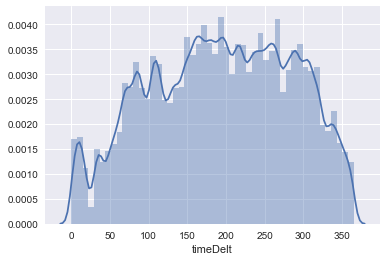

In [15]:
sns.distplot(bike2016['timeDelt'])

In [27]:
grouped = bike2016.groupby('timeDelt')['Year','Month','Day','timeDelt','startweekday'].max()
grouped['totalRents'] = bike2016.groupby('timeDelt')['timeDelt'].size()
grouped['timeDelt_sq'] = grouped['timeDelt'].apply(lambda s: s**2)
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 365
Data columns (total 7 columns):
Year            362 non-null int64
Month           362 non-null int64
Day             362 non-null int64
timeDelt        362 non-null int64
startweekday    362 non-null int64
totalRents      362 non-null int64
timeDelt_sq     362 non-null int64
dtypes: int64(7)
memory usage: 22.6 KB


In [17]:
#count rows per julian day per station id 'startlocID' (add count column)

In [30]:
groupedStart = bike2016.groupby(['startlocID','timeDelt'])[
    'Year','Month','Day','startweekday','timeDelt','startlocID'].max()
groupedStart['totalRents'] = bike2016.groupby(['startlocID','timeDelt'])['startlocID'].size()
groupedStart['timeDelt_sq'] = groupedStart['timeDelt'].apply(lambda s: s**2)
groupedStart.head(20)

Year  Month  Day  startweekday  timeDelt  startlocID  \
startlocID timeDelt                                                         
31000      0         2016      1    1             4         0       31000   
           2         2016      1    3             6         2       31000   
           3         2016      1    4             0         3       31000   
           4         2016      1    5             1         4       31000   
           5         2016      1    6             2         5       31000   
           6         2016      1    7             3         6       31000   
           7         2016      1    8             4         7       31000   
           9         2016      1   10             6         9       31000   
           10        2016      1   11             0        10       31000   
           11        2016      1   12             1        11       31000   
           12        2016      1   13             2        12       31000   
           13        2016      1   14             3        13       31000   
           14        2016      1   15             4        14       31000   
           15        2016      1   16             5        15       31000   
           17        2016      1   18             0        17       31000   
           18        2016      1   19             1        18       31000   
           19        2016      1   20             2        19       31000   
           28        2016      1   29             4        28       31000   
           29        2016      1   30             5        29       31000   
           30        2016      1   31             6        30       31000   

                     totalRents  timeDelt_sq  
startlocID timeDelt                           
31000      0                  1            0  
           2                  1            4  
           3                  8            9  
           4                  4           16  
           5                  1           25  
           6                  3           36  
           7                  2           49  
           9                  1           81  
           10                 5          100  
           11                 2          121  
           12                 4          144  
           13                 5          169  
           14                 5          196  
           15                 7          225  
           17                 1          289  
           18                 4          324  
           19                 2          361  
           28                 3          784  
           29                 1          841  
           30                 2          900

### Build a model

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: proximity to metro station <-- but is this redundant with station? could use for interpretation

#### Model steps: 
  - split data into train (2016) and test (2017)
  - initialize a model (e.g. linear regression)
  - cross validation

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import math

In [63]:
X = grouped[['timeDelt', 'timeDelt_sq']]
y = grouped['totalRents']

In [46]:
lr = LinearRegression(normalize=True)
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [60]:
scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print('mean r2:',np.mean(scores))

mean r2: -0.226379900519
